Loading Istanbul map...
Starting simulation... Close the window to stop.


/tmp/ipykernel_13529/1421549852.py:98: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = FuncAnimation(fig, update, frames=None, interval=200, repeat=False)


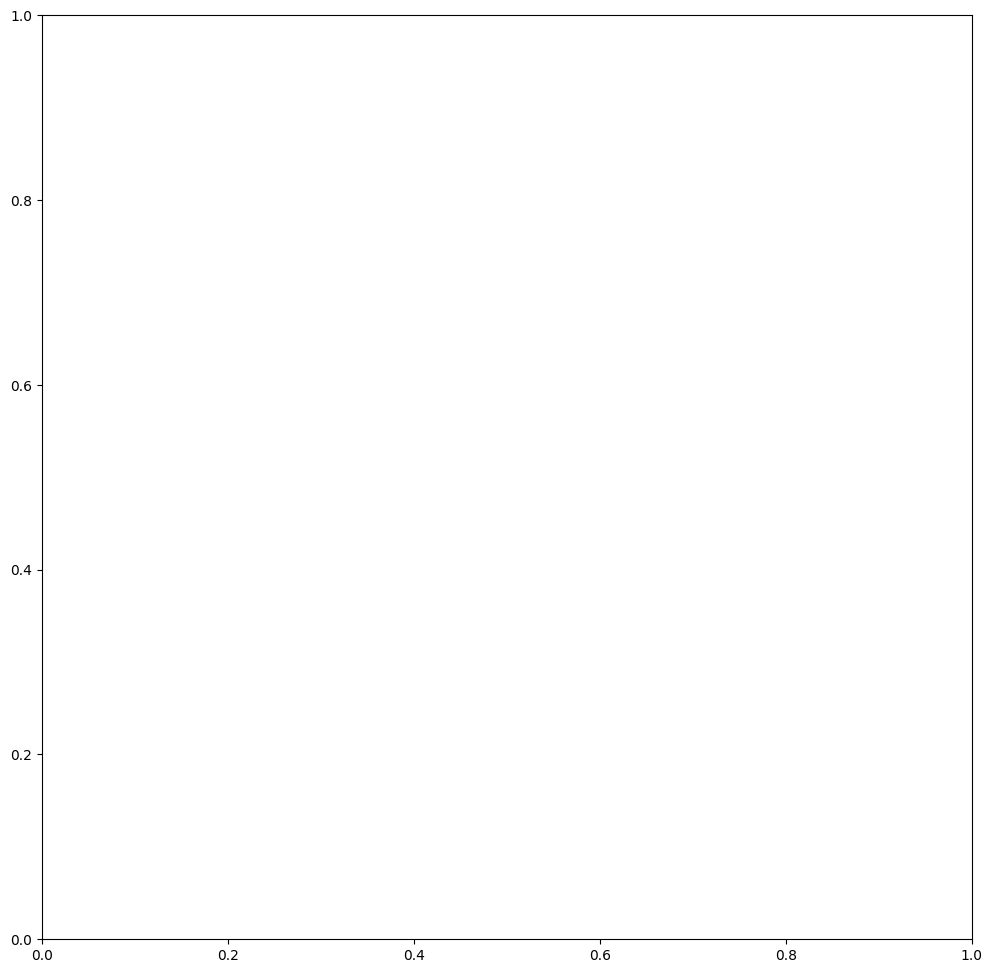

Simulation stopped.


In [2]:

import osmnx as ox
import networkx as nx
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Load Istanbul city graph
print("Loading Istanbul map...")
graph = ox.graph_from_place("Istanbul, Turkey", network_type="drive")
city_graph = nx.Graph(graph)

# Initialize traffic flow and car properties
num_cars = 20
traffic_flow = {edge: 0 for edge in city_graph.edges}  # Start with zero flow
car_positions = [random.choice(list(city_graph.nodes)) for _ in range(num_cars)]
car_speeds = [1.0 for _ in range(num_cars)]  # Initial speed factor

# Convert graph to node positions for plotting
positions = {node: (data['x'], data['y']) for node, data in city_graph.nodes(data=True)}

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 12))
running = True

# Function to stop the animation
def on_close(event):
    global running
    running = False

fig.canvas.mpl_connect('close_event', on_close)

# Plot base map
def plot_base_map():
    ox.plot_graph(city_graph, ax=ax, node_size=0, edge_color='gray', edge_linewidth=0.5, show=False)

# Update function for animation
def update(frame):
    global car_positions, car_speeds, traffic_flow
    
    if not running:
        anim.event_source.stop()
        return
    
    ax.clear()
    plot_base_map()
    
    # Update traffic flow and car movements
    new_positions = car_positions.copy()
    for i in range(num_cars):
        current_node = car_positions[i]
        neighbors = list(city_graph.neighbors(current_node))
        
        if neighbors:
            next_node = random.choice(neighbors)
            edge = (current_node, next_node)
            if edge not in city_graph.edges:
                edge = (next_node, current_node)
            
            # Update traffic flow
            traffic_flow[edge] = traffic_flow.get(edge, 0) + 1
            
            # Calculate speed based on traffic flow (1-5 lanes simulation)
            lanes = random.randint(1, 3)  # Simulating different street capacities
            flow_factor = min(1.0, lanes / max(1, traffic_flow[edge] * 0.1))  # Reduce speed with higher flow
            car_speeds[i] = max(0.1, flow_factor)  # Minimum speed of 0.1
            
            # Move car based on speed probability
            if random.random() < car_speeds[i]:
                new_positions[i] = next_node
    
    car_positions = new_positions
    
    # Visualize traffic flow
    for edge, flow in traffic_flow.items():
        if flow > 0:
            width = min(3.0, flow * 0.2)  # Scale line width with flow
            color = plt.cm.Reds(min(1.0, flow * 0.05))  # Color intensity based on flow
            nx.draw_networkx_edges(
                city_graph, 
                pos=positions, 
                edgelist=[edge], 
                edge_color=[color], 
                width=width, 
                ax=ax
            )
    
    # Plot cars
    car_x = [positions[node][0] for node in car_positions]
    car_y = [positions[node][1] for node in car_positions]
    ax.scatter(car_x, car_y, c='blue', s=20, zorder=5)
    
    ax.set_title(f"Traffic Simulation - Frame {frame}")
    return ax

# Create animation
print("Starting simulation... Close the window to stop.")
anim = FuncAnimation(fig, update, frames=None, interval=200, repeat=False)
plt.show()

print("Simulation stopped.")